# Start TF Session

In [1]:
import tensorflow as tf
import numpy as np
np.set_printoptions(suppress=True)

sess = tf.InteractiveSession()

In [7]:
# Imports for visualization
import PIL.Image
from io import StringIO
from IPython.display import clear_output, Image, display
import scipy.ndimage as nd
import scipy.signal
from pathlib import Path

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from typing import List

%matplotlib inline


In [4]:
img_path = Path("..")/"data"/"screenshots"/"ss.png"

# img_file = 'lichess_5.png'

# folder = "chessboards/input_chessboards"
# folder = "chessboards/test_chessboards"

img = PIL.Image.open(img_path)

print( "Loaded %s (%dpx x %dpx)" % \
    (img, img.size[0], img.size[1]) )

Loaded <PIL.PngImagePlugin.PngImageFile image mode=RGB size=974x1047 at 0x1C70867AAC8> (974px x 1047px)


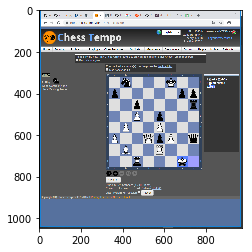

In [5]:


# Resize if image larger than 2k pixels on a side
if img.size[0] > 2000 or img.size[1] > 2000:
    print ("Image too big (%d x %d)" % (img.size[0], img.size[1]))
    new_size = 500.0 # px
    if img.size[0] > img.size[1]:
        # resize by width to new limit
        ratio = new_size / img.size[0]
    else:
        # resize by height
        ratio = new_size / img.size[1]
    print( "Reducing by factor of %.2g" % (1./ratio) )
    img = img.resize(img.size * ratio, PIL.Image.ADAPTIVE)
    print( "New size: (%d x %d)" % (img.size[0], img.size[1]) )

# See original image
#display_array(np.asarray(img), rng=[0,255])

imshow(np.asarray(img))

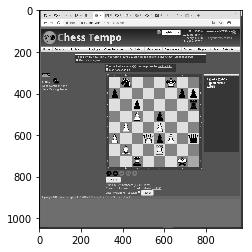

In [6]:
# Convert to grayscale and array
a = np.asarray(img.convert("L"), dtype=np.float32)

imshow(np.asarray(a), cmap='gray')

In [9]:
def make_kernel(a: List[List[float]]):
  """Transform a 2D array into a convolution kernel.
  TF needs the filter to be in 4d so this just appends 2 empty dimensions
  for channel & channel_multiplier
  """
  a = np.asarray(a)
  a = a.reshape(list(a.shape) + [1,1])
  return tf.constant(a, dtype=1)

def simple_conv(x, k):
  """A simplified 2D convolution operation"""

    # add extra dimensions for batch # at beginning and channels at end (-1)
  x = tf.expand_dims(tf.expand_dims(x, 0), -1)
  print(x)
    # data_format: The data format for input. Either "NHWC"
    # input 4-D with shape according to data_format
    # filter 4-D with shape [filter_height, filter_width, in_channels, channel_multiplier].
  y = tf.nn.depthwise_conv2d(input=x, 
                             filter=k, 
                             
                             strides=[1, 1, 1, 1], 
                             padding='SAME',
                            data_format="NHWC"
                            )

    # chop off the batch and channels empty dimensions
  return y[0, :, :, 0]

def gradientx(x):
  """Compute the x gradient of an array"""
  gradient_x = make_kernel([[-1.,0., 1.],
                            [-1.,0., 1.],
                            [-1.,0., 1.]])
  return simple_conv(x, gradient_x)

def gradienty(x):
  """Compute the x gradient of an array"""
  gradient_y = make_kernel([[-1., -1, -1],[0.,0,0], [1., 1, 1]])
  return simple_conv(x, gradient_y)

def corners(x):
  """Find chess square corners in an array"""
  chess_corner = make_kernel([[-1., 0, 1],[0., 0., 0.], [1.,0, -1]])
  return simple_conv(x, chess_corner)

# Following are meant for binary images
def dilate(x, size=3):
  """Dilate"""
  kernel = make_kernel(np.ones([size,size], dtype=np.float32))
  return tf.clip_by_value(simple_conv(x, kernel),
                          np.float32(1),
                          np.float32(2))-np.float32(1)

def erode(x, size=3):
  """Erode"""
  kernel = make_kernel(np.ones([size,size]))
  return tf.clip_by_value(simple_conv(x, kernel),
                          np.float32(size*size-1),
                          np.float32(size*size))-np.float32(size*size-1)

def opening(x, size=3):
    return dilate(erode(x,size),size)

def closing(x, size=3):
    return erode(dilate(x,size),size)

def skeleton(x, size=3):
    """Skeletonize"""
    return tf.clip_by_value(erode(x) - opening(erode(x)),
                            0.,
                            1.)

In [10]:
# Get our grayscale image matrix
A = tf.Variable(a)

# Get X & Y gradients and subtract opposite gradient
# Strongest response where gradient is unidirectional
# clamp into range 0-1
# Dx = tf.clip_by_value(np.abs(gradientx(A)) - np.abs(gradienty(A)),
#                       0., 1.)
# Dy = tf.clip_by_value(np.abs(gradienty(A)) - np.abs(gradientx(A)),
#                       0., 1.)

Dx = gradientx(A)
Dy = gradienty(A)

# Dxy = np.abs(gradientx(A) * gradienty(A))
# Dc = np.abs(corners(A))

Tensor("ExpandDims_1:0", shape=(1, 1047, 974, 1), dtype=float32)
Tensor("ExpandDims_3:0", shape=(1, 1047, 974, 1), dtype=float32)


In [ ]:
# Initialize state to initial conditions
tf.global_variables_initializer().run()

In [ ]:
fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
ax = fig.add_subplot(111)

ax.imshow(Dx.eval(), cmap='gray')

fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
ax = fig.add_subplot(111)
ax.imshow(Dy.eval(), cmap='gray')


# Hello
